--- Starting Setup ---
Using device: cuda

Input image found at: /kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg
--- Setup Complete ---

--- Installing/Verifying Dependencies (transformers, Pillow, open_clip_torch) ---
Dependencies (transformers, Pillow, open_clip_torch) installed/verified successfully.


2025-04-20 09:08:15.896126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745140095.918289     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745140095.925175     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



--- Loading Baseline CLIP model: openai/clip-vit-base-patch32 ---
Baseline CLIP model loaded successfully.

--- Loading and Displaying Image ---
Successfully loaded image from: /kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg


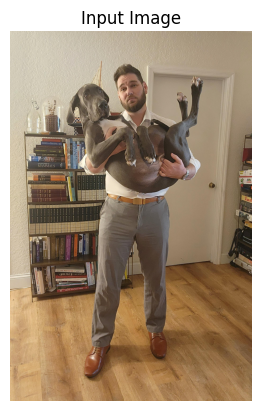


--- Calculating Similarity Scores with Baseline CLIP ---


model.safetensors:  15%|#5        | 93.4M/605M [00:00<?, ?B/s]

Baseline CLIP Scores (Logits):
- 'A person and a dog sitting on the grass.': 23.7514
- 'A human petting their golden retriever.': 24.2050
- 'A man's best friend.': 26.5426
- 'Outdoor scene with a canine and its owner.': 24.2815
- 'A happy dog next to a person.': 26.2364
- 'Two cats playing indoors.': 24.3914
- 'A landscape photo of mountains.': 14.0426
- 'A portrait of a dog.': 22.4430
- 'Someone relaxing outside with their pet.': 24.7869
- 'A close-up of a dog's face.': 15.2554

--- Loading Enhanced CLIPS model: hf-hub:UCSC-VLAA/ViT-L-14-CLIPS-Recap-DataComp-1B ---


open_clip_pytorch_model.bin:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Enhanced CLIPS model, preprocessor, and tokenizer loaded successfully from Hugging Face Hub.

--- Calculating Similarity Scores with Enhanced CLIPS ---
Enhanced CLIPS Scores (Logits):
- 'A person and a dog sitting on the grass.': 5.0195
- 'A human petting their golden retriever.': 8.3750
- 'A man's best friend.': 23.2969
- 'Outdoor scene with a canine and its owner.': 10.2266
- 'A happy dog next to a person.': 16.2656
- 'Two cats playing indoors.': 9.9062
- 'A landscape photo of mountains.': 3.3008
- 'A portrait of a dog.': 12.8047
- 'Someone relaxing outside with their pet.': 8.8281
- 'A close-up of a dog's face.': 8.8516

Description                                        | Baseline CLIP   | Enhanced CLIPS 
-------------------------------------------------------------------------------------
A person and a dog sitting on the grass.           | 23.7514         | 5.0195         
A human petting their golden retriever.            | 24.2050         | 8.3750         
A man's best friend. 

In [1]:
print("--- Starting Setup ---")
import torch
import os
import sys
import warnings
from PIL import Image
import matplotlib.pyplot as plt # For displaying image
import subprocess # To run shell commands like pip
import torch.nn.functional as F # For normalization

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
# Input Image Path (Fixed as per requirement)
IMAGE_PATH = "/kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg"

# CLIPS Model Identifier on Hugging Face Hub (from the inference example)
CLIPS_HF_MODEL_ID = 'hf-hub:UCSC-VLAA/ViT-L-14-CLIPS-Recap-DataComp-1B'

# Baseline CLIP Model Name
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"

# --- Device Setup ---
# Ensure GPU is enabled in Notebook settings (Accelerator -> GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Warning: Running on CPU. Computations will be slow. Enable GPU in notebook settings (Accelerator -> GPU).")

# --- Sample Text Descriptions ---
text_descriptions = [
    "A person and a dog sitting on the grass.",
    "A human petting their golden retriever.",
    "A man's best friend.",
    "Outdoor scene with a canine and its owner.",
    "A happy dog next to a person.",
    "Two cats playing indoors.", # Distractor text
    "A landscape photo of mountains.", # Distractor text
    "A portrait of a dog.",
    "Someone relaxing outside with their pet.",
    "A close-up of a dog's face."
]

# --- Path Existence Check for Input Image ---
image_exists = os.path.exists(IMAGE_PATH)
if not image_exists:
    print(f"\nError: Input image not found at '{IMAGE_PATH}'.")
    print("Please ensure the Kaggle input data source 'cv-homework-3' is correctly added to the notebook.")
    assert False, "Input image path invalid."
else:
    print(f"\nInput image found at: {IMAGE_PATH}")

print("--- Setup Complete ---")


print("\n--- Installing/Verifying Dependencies (transformers, Pillow, open_clip_torch) ---")
try:
    # Install both transformers (for baseline CLIP) and open_clip (for the new CLIPS)
    subprocess.run([sys.executable, "-m", "pip", "install", "transformers", "Pillow", "open_clip_torch", "--quiet"], check=True)
    print("Dependencies (transformers, Pillow, open_clip_torch) installed/verified successfully.")
    # Import necessary libraries after installation
    from transformers import CLIPProcessor, CLIPModel
    import open_clip # For the new CLIPS model
except subprocess.CalledProcessError as e:
    print(f"Error installing dependencies: {e}")
    print("Please check internet connectivity in notebook settings.")
    assert False, "Dependency installation failed."
except ImportError as e:
    print(f"Error importing libraries after attempting installation: {e}")
    assert False, "Dependency import failed."

print(f"\n--- Loading Baseline CLIP model: {CLIP_MODEL_NAME} ---")
clip_model = None
clip_processor = None
try:
    # Transformers library handles caching
    clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
    clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
    clip_model.eval() # Set to evaluation mode
    print("Baseline CLIP model loaded successfully.")
except Exception as e:
    print(f"Error loading baseline CLIP model: {e}")
    print("Ensure internet is enabled in notebook settings if model isn't cached.")
    assert False, "Failed to load baseline CLIP model"


print("\n--- Loading and Displaying Image ---")
image_pil = None # Use a distinct name like image_pil for the PIL image
try:
    image_pil = Image.open(IMAGE_PATH)
    print(f"Successfully loaded image from: {IMAGE_PATH}")
    # Display the image in the notebook
    plt.imshow(image_pil)
    plt.title("Input Image")
    plt.axis('off') # Hide axes
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file not found again at {IMAGE_PATH}. Path check failed earlier or file removed.")
    assert False, "Image load failed"
except Exception as e:
    print(f"Error loading image: {e}")
    assert False, "Image load failed"


print("\n--- Calculating Similarity Scores with Baseline CLIP ---")
clip_similarities = {}
if clip_model and clip_processor and image_pil: # Check if model, processor and image loaded
    with torch.no_grad(): # Disable gradient calculations for inference
        try:
            inputs = clip_processor(text=text_descriptions, images=image_pil, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            clip_scores = logits_per_image.squeeze().cpu().numpy()

            print("Baseline CLIP Scores (Logits):")
            for desc, score in zip(text_descriptions, clip_scores):
                clip_similarities[desc] = score
                print(f"- '{desc}': {score:.4f}")
        except Exception as e:
            print(f"Error during baseline CLIP inference: {e}")
            # Allow continuing if only CLIP fails
else:
    print("Baseline CLIP model/processor or image not loaded correctly. Skipping baseline CLIP calculation.")


print(f"\n--- Loading Enhanced CLIPS model: {CLIPS_HF_MODEL_ID} ---")
clips_model = None
clips_preprocess = None
clips_tokenizer = None

if 'open_clip' in sys.modules: # Check if open_clip was imported successfully
    try:
        # Load model and preprocessing function directly from Hugging Face Hub
        # This handles download and caching automatically
        clips_model, clips_preprocess = open_clip.create_model_from_pretrained(CLIPS_HF_MODEL_ID)
        clips_model.to(device)
        clips_model.eval()

        # Get the corresponding tokenizer
        clips_tokenizer = open_clip.get_tokenizer(CLIPS_HF_MODEL_ID)

        print("Enhanced CLIPS model, preprocessor, and tokenizer loaded successfully from Hugging Face Hub.")

    except Exception as e:
        print(f"Error loading CLIPS model using open_clip from Hugging Face Hub: {e}")
        print(f"Model ID: {CLIPS_HF_MODEL_ID}")
        print("Ensure the Hugging Face Hub ID is correct and internet is enabled.")
        assert False, "CLIPS model load failed - Runtime Error from Hub"
else:
     print("Error: open_clip module not available. Cannot load CLIPS model.")
     assert False, "open_clip missing"


print("\n--- Calculating Similarity Scores with Enhanced CLIPS ---")
clips_similarities = {}
# Use autocast for potential speedup and memory saving on GPU
enable_autocast = (device == 'cuda')

if clips_model and clips_preprocess and clips_tokenizer and image_pil: # Check if CLIPS components and image loaded
    # Use autocast context manager for mixed precision inference if on GPU
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=enable_autocast):
        try:
            # Preprocess the PIL image using CLIPS's preprocessor
            # Note: Changed variable name to image_input_clips to avoid conflicts if needed later
            image_input_clips = clips_preprocess(image_pil).unsqueeze(0).to(device)

            # Tokenize the text descriptions
            # Using context_length from the loaded model is good practice if available
            context_length = clips_model.context_length if hasattr(clips_model, 'context_length') else 77 # Default CLIP context length
            text_inputs = clips_tokenizer(text_descriptions, context_length=context_length).to(device)

            # Get image and text features
            image_features = clips_model.encode_image(image_input_clips)
            text_features = clips_model.encode_text(text_inputs)

            # Normalize features (as shown in the CLIPS example code)
            image_features = F.normalize(image_features, dim=-1)
            text_features = F.normalize(text_features, dim=-1)

            # Calculate cosine similarity scaled by the learned temperature (logit_scale)
            # Check if logit_scale exists and is a parameter/tensor
            if hasattr(clips_model, 'logit_scale') and isinstance(clips_model.logit_scale, (torch.nn.Parameter, torch.Tensor)):
                 logit_scale = clips_model.logit_scale.exp()
            else:
                 # If logit_scale is not available or not learned, use a fixed scale (e.g., 100 is common in CLIP)
                 # Or inspect the model object to see if temperature is stored differently
                 print("Warning: logit_scale not found or not a tensor in CLIPS model. Using fixed scale 100.0.")
                 logit_scale = torch.tensor([100.0]).to(device)

            # Calculate logits = scale * <normalized_image_feat, normalized_text_feat>
            similarity_logits = (logit_scale * image_features @ text_features.T) # Shape: [1, num_texts]

            clips_scores = similarity_logits.squeeze().cpu().numpy()

            print("Enhanced CLIPS Scores (Logits):")
            for desc, score in zip(text_descriptions, clips_scores):
                clips_similarities[desc] = score
                print(f"- '{desc}': {score:.4f}")
        except Exception as e:
            print(f"Error during CLIPS inference: {e}")
            # Allow continuing if only CLIPS fails
else:
     print("CLIPS model/preprocessor/tokenizer or image not loaded correctly. Skipping CLIPS calculation.")


# Check if both results dictionaries were populated
if not clip_similarities:
    print("\nBaseline CLIP similarities were not calculated. Cannot provide baseline CLIP column.")
if not clips_similarities:
    print("\nEnhanced CLIPS similarities were not calculated. Cannot provide CLIPS column.")

# Proceed only if at least one set of results exists
if clip_similarities or clips_similarities:
    print(f"\n{'Description':<50} | {'Baseline CLIP':<15} | {'Enhanced CLIPS':<15}")
    print("-" * 85)
    for desc in text_descriptions:
        # Use .get() with a default value (e.g., NaN) for safe access
        clip_score = clip_similarities.get(desc, float('nan'))
        clips_score = clips_similarities.get(desc, float('nan'))
        print(f"{desc:<50} | {clip_score:<15.4f} | {clips_score:<15.4f}")
else:
    print("\nNeither Baseline CLIP nor Enhanced CLIPS similarities were calculated. No comparison table to display.")

